In [1]:
import torch
import torchvision
import numpy
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from nuscenes.nuscenes import NuScenes

In [4]:
nusc = NuScenes(version='v1.0-mini', dataroot='./', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [6]:
myscene = nusc.scene[1]
myscene

{'token': 'fcbccedd61424f1b85dcbf8f897f9754',
 'log_token': '53cf9c55dd8644bea67b9f009fc1ee38',
 'nbr_samples': 40,
 'first_sample_token': '3e8750f331d7499e9b5123e9eb70f2e2',
 'last_sample_token': '281b92269fd648d4b52d06ac06ca6d65',
 'name': 'scene-0103',
 'description': 'Many peds right, wait for turning car, long bike rack left, cyclist'}

In [7]:
# get a list of all categories
import os
import json

cat = []
json_file = "./v1.0-mini/image_annotations.json"
with open(json_file) as f:
    image_anns = json.load(f)

for entry in image_anns:
    cat.append(entry["category_name"])

unique = list(set(cat))
print(unique)

['human.pedestrian.construction_worker', 'movable_object.trafficcone', 'vehicle.construction', 'movable_object.pushable_pullable', 'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'vehicle.trailer', 'vehicle.motorcycle', 'vehicle.bus.rigid', 'vehicle.bicycle', 'static_object.bicycle_rack', 'vehicle.bus.bendy', 'movable_object.barrier', 'human.pedestrian.adult', 'human.pedestrian.child', 'vehicle.car', 'movable_object.debris', 'vehicle.truck']


In [8]:
print(len(unique))

18


In [9]:
def conv_catname_to_num(cat):
    if cat == "movable_object.barrier":
        return 0
    elif cat == "vehicle.bicycle":
        return 1
    elif cat == "vehicle.bus.rigid" or cat == "vehicle.bus.bendy":
        return 2
    elif cat == "vehicle.car":
        return 3
    elif cat == "vehicle.construction":
        return 4
    elif cat == "vehicle.motorcycle":
        return 5
    elif cat == "human.pedestrian.adult" or cat == "human.pedestrian.police_officer" or cat == "human.pedestrian.child" or cat == "human.pedestrian.construction_worker":
        return 6
    elif cat == "movable_object.trafficcone":
        return 7
    elif cat == "vehicle.trailer":
        return 8
    elif cat == "vehicle.truck":
        return 9
    else:
        return 10

In [13]:
from detectron2.structures import BoxMode
def get_dicts(img_dir):
    json_file = "./v1.0-mini/image_annotations.json"
    with open(json_file) as f:
        image_anns = json.load(f)

    dataset_dicts = []
    proc_files = []
    for v in image_anns:
        if v["sample_data_token"] not in proc_files:
            proc_files.append(v["sample_data_token"])
            print(v["sample_data_token"])
        else:
            continue
            
        record = {}
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = v["sample_data_token"]
        record["height"] = height
        record["width"] = width

        objs = []
        for ann in image_anns:
            if ann["sample_data_token"] == record["image_id"]:
                obj = {
                    "bbox": ann["bbox_corners"],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": conv_catname_to_num(ann["category_name"])
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [11]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train"]:
    DatasetCatalog.register("nusc_" + d, lambda d=d: get_dicts("./"))
    MetadataCatalog.get("nusc_" + d).set(thing_classes=["barrier", "bicycle", "bus", "car", "construction_vehicle", "motorcycle", "pedestrian", "traffic_cone", "trailer", "truck", "void"])
nusc_metadata = MetadataCatalog.get("nusc_train")

In [14]:
dataset_dicts = get_dicts("./")

e3d495d4ac534d54b321f50006683844
d0d9ef23e3934ea09d55afdc24db9827
4b6870ae200c4b969b91c50a9737f712
74e7a9260c5d45b78b831528b62daf41
21ca7cbfbde14f088143cf001570d01b
33b500c9cc824733a47bfe2c3ea33202
ddbc1befa70f4b49a0824f63a920676b
c311678f400e471d84e785652dd87a7a
885472e412f4499cacf2f4796c309276
81b6368f6af9417684cefeb6661a14e7
a61bfbde6877413386a772591617f38d
6c913201b35146eea7a2ed8c3fe43887
5941e77ca4bd478e99e17114ca8759ab
3ead6ff0cd324d92918112dfcf400343
e0bc3ff06fe348fdb56039c640be0ac3
addcad764798404b8141c9d40b413e73
06c1523315b14aa7a0dfa4afacafb9e6
357a06d0a5a44506b161c072c7247807
5aed4c34988b4c18a33c69ddcddb6010
3789c6c9d01449e7baf981a6f185825d
c9d8cf50e42b47fa9a0bbd923e5e9c30
8fe9b9f55bd14e25b8fde193d6b6a503
6bd85a6773944798ae0be117d40d4fdc
6c8111f474b943f589b4da1e3444c1c0
426b7a257a5a4fcbbf1086a335f9c648
e41335fbfc1645faa5a532a62df1fe68
4bc3a28622964e9f9ab28a68614189f1
5979f20786b745c5b05c21d8badc2ed8
ad609ca688444331b3218f664d644473
e2dc487869f546c39ee01ebba7ec434e
95c58e12ca

562a992ab3724ba1873439cb5aa79c5f
2548b0212b9b4356b3754f9aff505fba
3152f3fe99a545b3a7af4019965f4973
43690f8cf9e8472eae04d06de838217a
d9a8ad39503a411a8eb7501846d8dfc9
30f3278766a040469851546a499aeddd
059ffc35578745c3b625011b0479a4fa
4d56d35168514019a3f2f6f39b1b54d5
47bac577996844c78919b53fa36cf1ed
6d2aceca30d140c2ada255c5289f2589
2d3b48e3840244c7b681cb6e63e2c123
8464c748ca5f460dba24b50a233692e4
16c0e0687dda444285817f7ccd3387b5
ca13d9d6fa0742b7b7ad59e30b474ba9
883020ef0286455bbb4b91bc12f642ac
1afba7064f794174a68582db8e099c80
87723668b00f419ba263ab062d14bd13
55f48b2af8cd469a9d62c0907c34ff98
d5061556971945c2afc03dbfdc3bc1a6
81430db44c1b4d7994e00462485ef378
0f4c0e7301424f2996d87a86902aafe9
ae6645e8bf474b65b19a69bf71fe90a3
aeffd15cbe594a9a81b26d8bb8d15f3d
a2c24cc688ad408aa714c0015dfe8cc8
33504582dc914a6e9aca0a2d3ce8cf10
5ed84fb1dbe24efcb00eb766a22d69d6
9b5f2fe9db414397a3830035bcab3db4
8dd67485584c49ff97938ef6acf0db69
ee6216bfb2604794bf6d50965f9c299d
61239acb508f4f0da622fa32648ee565
52182a3eba

75474948f93e4a15b4153f9c52f0747e
4b24951396b14c428eb3c59c985b0c78
0839e821f0794b05a0f0dc6cce034265
aeae6f7b9b154cae9dfbd64705a4e540
12ed78f3bf934630a952f3259861877a
9c74852d4e3b48fbb8ce426686ce4087
d359e302482e48c5ad6ffb0851f6e69d
58dffd3b9d4448eebfe91e3046d7a6a9
ae30a66f4eaf4966b0378d77472b4ecb
4b2782334f684c51b0091b9e32c09547
5486348c154a4d04a99299c4134adac8
d412f172c8604b969b3ef56e137f9e23
d5595f9918f44ba3b0582ed3d4eed3c8
d63a68bd0b63426e97dc451a70e1b9d2
bd0ce9c48550446fa13676c7703a70c1
2e9a1aa477e04178a2ba5d43873222b0
9b30cb1c719d4ff48b747ee3ce05b781
f746f82ef4584fb7a4390a6d4b42af38
b60b1497a35d48759465705aeb613fe1
b6715593140346058ca79270bdf76edd
5da006cf3c60492faf9b78327c6c16f6
201469bcf8d64221a351d35017d67b24
fb352c909f844448adcb1881754228c9
75a0b248d68c4cd6bc350859d853cdf2
9143205fefb24b149a8fdd559a8c5578
b33a7298dce6479f902ce78874c72969
93b7f66616a8498783b8160ba836c79c
c74609d72bf14b7eb99909a95724af84
9e2595c41cab4248909b1991b030b3f4
08692c30bb8c497a8dd1d8c844eaaaf8
416b81e461

0cdb6b298b814b38bf9d7544f7f502a5
b44099882c0b40c8864d932b7abb78a5
b5f28784bc4045a7aa4c15064046b257
66a91a731fad4815a89a31ebebd8ecda
9ab262e92d67476a915f9695a982d641
98ff109481a14fc3b8534a917a8e8c96
9bf6028089e9429b9d488f8e270dba91
095ba57efbf84ea9b0684daf2e571342
b041ebb531a74699bd20f050c9c5693b
b8eb890b22244129b3a0f839abfcbb43
121a726bdf4644a78d2a08b8dd9a5d6a
6e8a45686c9245f4816afd18b88073ec
e1b8e1f550194ea99a34cb05d2d47406
2e51f006a4634ade806c5059d89aa1bc
148285ec2ce8466c8d0a444704114d78
8df992b5f6224db1af92050766ef08d1
e9568fb548564d38b6fa3e811ba712c4
113c459f917541a2bb0f62d63e6bd1e2
115b1dcf976a48f3a933813769daa941
8140e0d584a448ddac2befd221508790
3ca891eff7b6467db85909fcb341cb14
63b083b5e5b54a26a567ba26f4e1b53b
59c829c9b03e47ac949ca60426dc6c34
4f654200d583468f95375d155efd42f7
c92652812b734bdda82cce407057298b
618c9499620a47f78a642737da04cb80
107d7a95ffd74b9ba6c4dae99a8d0284
4bf82a3b22e043fabc15f850970c1f2c
64d14a162771459f9ff6396c99dcee75
e29a1f2499c34a5aa83cf8e51d2cb574
db447c300e

b80b89d28aed48c9810044e17754b4b9
6040b4ad270843fea46e8e96ac3aed51
29fc0694c83042fb91a21728fc30d8c4
41634fb161b14935a7e657ddec6f0bb6
ff2a2d54adb04e1cb905fff62b27b4f1
391e4bba7e3f4eb4bfa300961c66bc72
c9fd2384be464dd195080149424d94ee
791f27cef3374fa6a23a7e26533da1b1
9e8d67ff20804a25839467aa17d1913f
4e34f1ce12154ab382fc27f90ea487f2
ea4ec0fe87994bf4b1d3a28c270fa8a5
5ac334f4af3d40709f34f77cef0a8fc6
12c3f36cc3b94d64bd079698d22e9a65
cad69f6d34c14feba05f0be3e779ac68
f3ffbf4ec43741a49f3375b29caf1306
53ca62017b4c4e0caad2380f3dc5ae7a
0cdf4527a58d472c85133e4f36708578
a6bf8ef635664427a5acd767483dcdba
3ca3e689f1ec4148a480f201a66b6658
18d1c553782d4d19802b9ded5f70cd60
f4b602b96968491aad9c336737df72ad
92f835a2c53a416c89d78faadaef22db
55330b0607d746e6adf9ff5bbde3b6ba
c812d671ef3c438db72909374e1a75b2
40d90726cc384975979e29e01f53bdf8
973821149f0f46fcb59944bced802524
e1979a40cc384c1c8e9ff0bdeea2ad29
14e6ad56d3d24cfea2d12b0ac0ba66fb
c300ed887a9e4ceea2c6b65c7304fce0
278ba2a24ce04cafb89fec68c6e90271
79f07d923a

1eb0e7fde2c941f194598a77b3d3b2f8
b8e38749a9f1404597fe3b1d28cf94cb
d6d4bc9e691b40e78044b84a91efafab
4e2a4ae17f0542f38775025c37fa3bcb
3d06fcecb63149bab2ec62b04fb797ae
d531bb333fed429ba8a96a2944dd48cb
ae4ff39cd4514954b36c8989e17e6690
1270f2f3675b407fb1299c7ff84b006c
72a12f5ab2124e0ea0eac44843db4a3b
579b4214e58544d1921331abca2cf18c
ba4f824bbbc14147b0106ff10360d906
cc3b339a65bc493f9eb84b54b3a21a4c
4d111360416844ad9c12321132a55d3b
6808ff7d60a945fa855959cae7fa5737
f3664ffaf2b445ee9b7309b885aa55f5
1468501e5f9a465996c82ff280275b75
0be976cc26b84b4ea833e481189598a0
c65b45cacdc4486cb4e07e01c9edfda1
4c84aed52e8e4bc5b1b413e7416bcf63
fa07424d74e34dfc8f98aed3c944d191
b5f0264dcc25460183caee62d214aa32
b1576e58cc2d4eee8f180e69613d9268
3c7175f5ebe34b45af3a5ac750ff2604
70df389eb7a04df6ae6a6cd00da878bd
5c95a49c34454cd8a9268520a9c14df5
fff01000c8b9467faf6c4aff9bdbbbf7
f92faf0bc24942d8ac44a479eef983a5
9706ab2aaf304042bfb731ebf33b35d8
be22879d93f04150bb9466211012205e
1ae3cf851f95462baf891844258ca6bc
0bf6641f73

6b540a3724a1423ab8fb9b7c626a6902
e69ed8a458ec484f9fac96d0b5111d24
c5e7618c503b4330b1c332bdef57da3a
ec94066c0bd54b6699fb1c55ad929670
16fbf5418a204505a0f5e6f91ecdc05b
b9027adb05004ec5a6f495ce3f6d5175
b390687411224f808bfe06cd479a73d8
d5303aa4632e4b67812b863004b796b9
7bd7f59a3c7d4e40a12dd999c2c0853b
d819d6234d0c4b0a9969fbf876324134
61035e131d8e4af98d245923ee7a9bc1
ceb9c41a572d48738663a840adfa9368
e93a7c7e40504c8a86b40154cd1d02e2
fd74954063484c58b9f4d43fbdfa430b
520dd0839226415db8d2e28a72937dd2
4c253531ba9841cb9ac04c950feb69d6
a01527073c9b4256b268d2c1fb686460
d8f1ceb8d5cd45f4a665b0f8f90ed92a
d922946302294bcbb73254ed3f6b8fa2
b1f88de5dbfb4431809220f1638f314a
7f5690baf4f84f408e5bfcb765fdc82b
3d7a899d923c41208877d4842589b791
ddecbdd563ec4e33aa1e9375db402f32
32e0a3e397a0481997a911c42920e136
c8d4af7d08db4ceaa52bbbd08ba55b80
16818061f8b848ee8bde84823c1f97d3
63943a0873384daf8292972da82f482a
5f6604763a9c4bea8e267c0e716603f3
d79d9a38c0324ff6a2c9da2deb24da77
8590cebe48ef43c3a431c577e51e80f1
b0b35f63ed

d7330cd5962148fc916a277e8fa8a0e8
0ed3f1797f7440a39f93be12b852adee
be6fb7ba760d4c94834582f6ad761252
dbfa650384564594906313c18c49c9e6
eed2863fa9f74b1b89b6f60ded77d9a9
f598d2c67f5b4b91afd4d96f0a8f1e4e
e39d8498f61e4053b47b41fb297d66ea
dd508289c957487b969d55c879df3781
720a7aa4cb6c49c7ae26c748323af4ab
8233dc33889341648a3b873aca8df7c6
552b0ec30c78436e8ea464cff1c604a3
d77a138a272b4ebcbbe509afa6ef241a
4e4858e6e8cf442aa77238755f7a4d4a
f567ac89901f4f81b4f65fed6aa1f93c
243364c317fa40cca58f8ed708a0bf88
5cd71932637b4529939203433c8a26d2
f74877ed3166478abb14d1373ecaf917
56072cc5d1c0409b9b55e4fc49248579
5f37f8e5715b48a7ab08dcf546c90e42
d5334379c54d4fd28c6a895a6cb38a86
30877d615d7a457a81b9b14e4f6faa95
cdccd1d62b024ac0bbc31201fcec6a22
766bb42c19b541fd82e7927d0e657eb3
90e01def881c48e4876ee016315103ae
03b2b0e2a87e4d9aa180555289b1ac05
924532ce689d460382e63c4b77c96b7a
a8d39f49db0e4958bac3e7aac3c0df59
71fceeb0c69a427a8b63dbcf8a9cca0b
53d985c7ed8c4ce8b24510c1b8d126d1
5929dc8a7bcc4d7b819e8bc27002e078
5142afdadd

44f96976839646da8fd9a2503770679b
c97f913a7189468ab989472ca23cd2f7
9a424dcc6eea4121b95dd7866b3a2747
d72aa3fb63d74d9094cf81885c9324f4
38c97a2de1cf466188b301c93b09cf90
d9dfe1e2c69f43569e1d647db300c25e
f2d87f0aab464579b52314573185f82a
d071e14b04f4426ea92ac04f78b6a3da
f92f1f3680f348c8b317e4f7a9048eb1
51d0a142db454333974bb434dc3145a3
b4e58d0efa0e4fab929e1b1d4179eeec
f2288c157e144fdfa585ac5ea9328175
622ad9f1e9f947218d3b21da59f23073
17a18c3a66e34dd8afb523d060790251
62f2f587354b4f0fa8954447394a0df4
62f882fe0d78466c83dc07f1a67d2b8f
72bafcb59cd24aba95e7efdb4f1603cd
f352e9bedbee4b0e95cee6ced6068d46
35e66974fe1d4713abd85931f4e3c0c1
6879100a501e49fab6aabe3c9666b6f7
6ee8b705c8e1484baefd62500d34ca63
ffb9f450f5ab4c7aa8fa18d3b24f08a2
646b51a45a2b4494a918ff89d36027e2
790b095a34794a48b525ed36b876c11e
1985a8418a644d30af0de82e79cf6f89
aec8f9edac744cecb4979b5bb9b0227f
b0e2b90b6c7e4007a7d5d7899f9cc0ba
bef4ef3895714e24a7f8ebd16c1826fe
43d9b109dc97461f802a714ae3b40e8f
84e6e4a520694d058c6b4e0607e2c81c
216b42f8dd

In [15]:
print(len(dataset_dicts))

2177


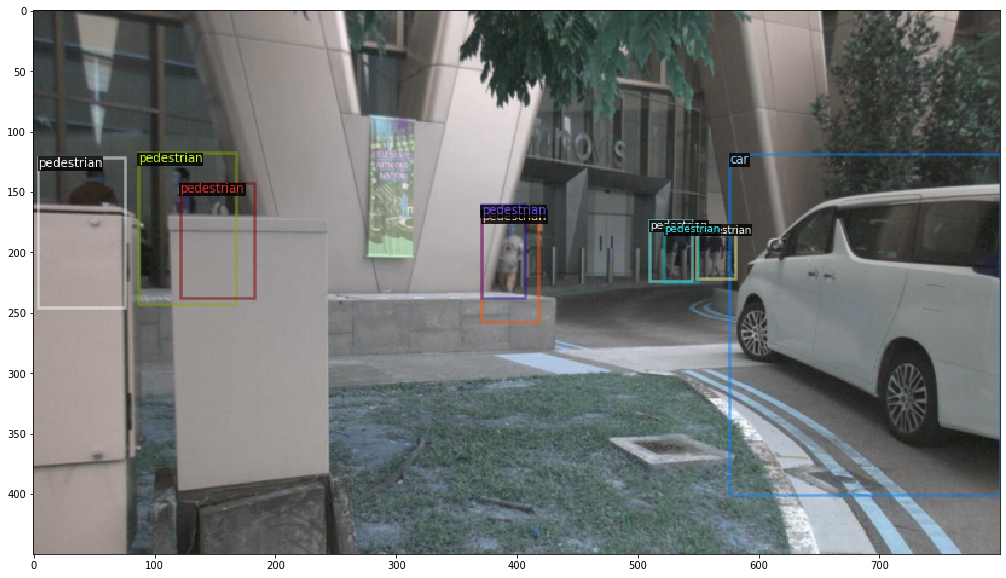

In [24]:
plt.rcParams['figure.figsize'] = [20, 10]
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=nusc_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()